# 0. Установка библиотек

In [ ]:
pip install torch transformers openpyxl

In [ ]:
pip install --upgrade pip pandas openpyxl

In [ ]:
pip install scikit-learn

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import numpy as np
import tinkoffpy as tf
import openpyxl
import requests
from tqdm.auto import tqdm
import re
import sklearn

# 2. Выгружаю датафрейм

In [ ]:
df_base = pd.read_excel('sd_research.xlsx', engine='openpyxl')
pd.set_option('display.max_colwidth', None)
df_base

# 2.1 Чищу и преобразовываю датафрейм

In [ ]:
# df_clear = df_base.replace({r'\n': '',
#                            r'(\*+)': ''}, regex=True)
df_clear.to_csv('sd_research_clear.csv', index=False)

# df_clear.to_csv('base_df_df.csv', index=False)
# df_clear.to_excel('base_df_df.xlsx', index=False, engine='openpyxl')
# pd.read_csv('base_df_df.csv')

# text_df = df_clear['text']
# target_df = df_clear['target']
# target_df

# df_clear['target'].value_counts()
# df_test = df_clear[10:500]
# df_test

# 3. Модели
## Наивный Байес (на исходных данных)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

# 1. Загрузка данных
data = df_clear  # Замените названия столбцов при необходимости
X = data['text']
y = data['target']

# 2. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Векторизация текста с помощью TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Можно настроить параметры
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 4. Обучение модели Multinomial Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# 5. Предсказание вероятностей для тестовой выборки
y_prob = model.predict_proba(X_test_tfidf)[:, 1]  # Вероятности для класса 1

# 6. Расчёт TPR, FPR и ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Вывод ROC-AUC
print(f"ROC-AUC: {roc_auc:.2f}")

# 7. Построение ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Линия случайного угадывания
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# # 5. Предсказание и оценка модели
y_pred = model.predict(X_test_tfidf)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# 6. Пример предсказания для нового текста
# new_text = ["пример нового текста для классификации"]
# new_text_tfidf = vectorizer.transform(new_text)
# prediction = model.predict(new_text_tfidf)
# print(f"Предсказанный класс: {prediction[0]}")


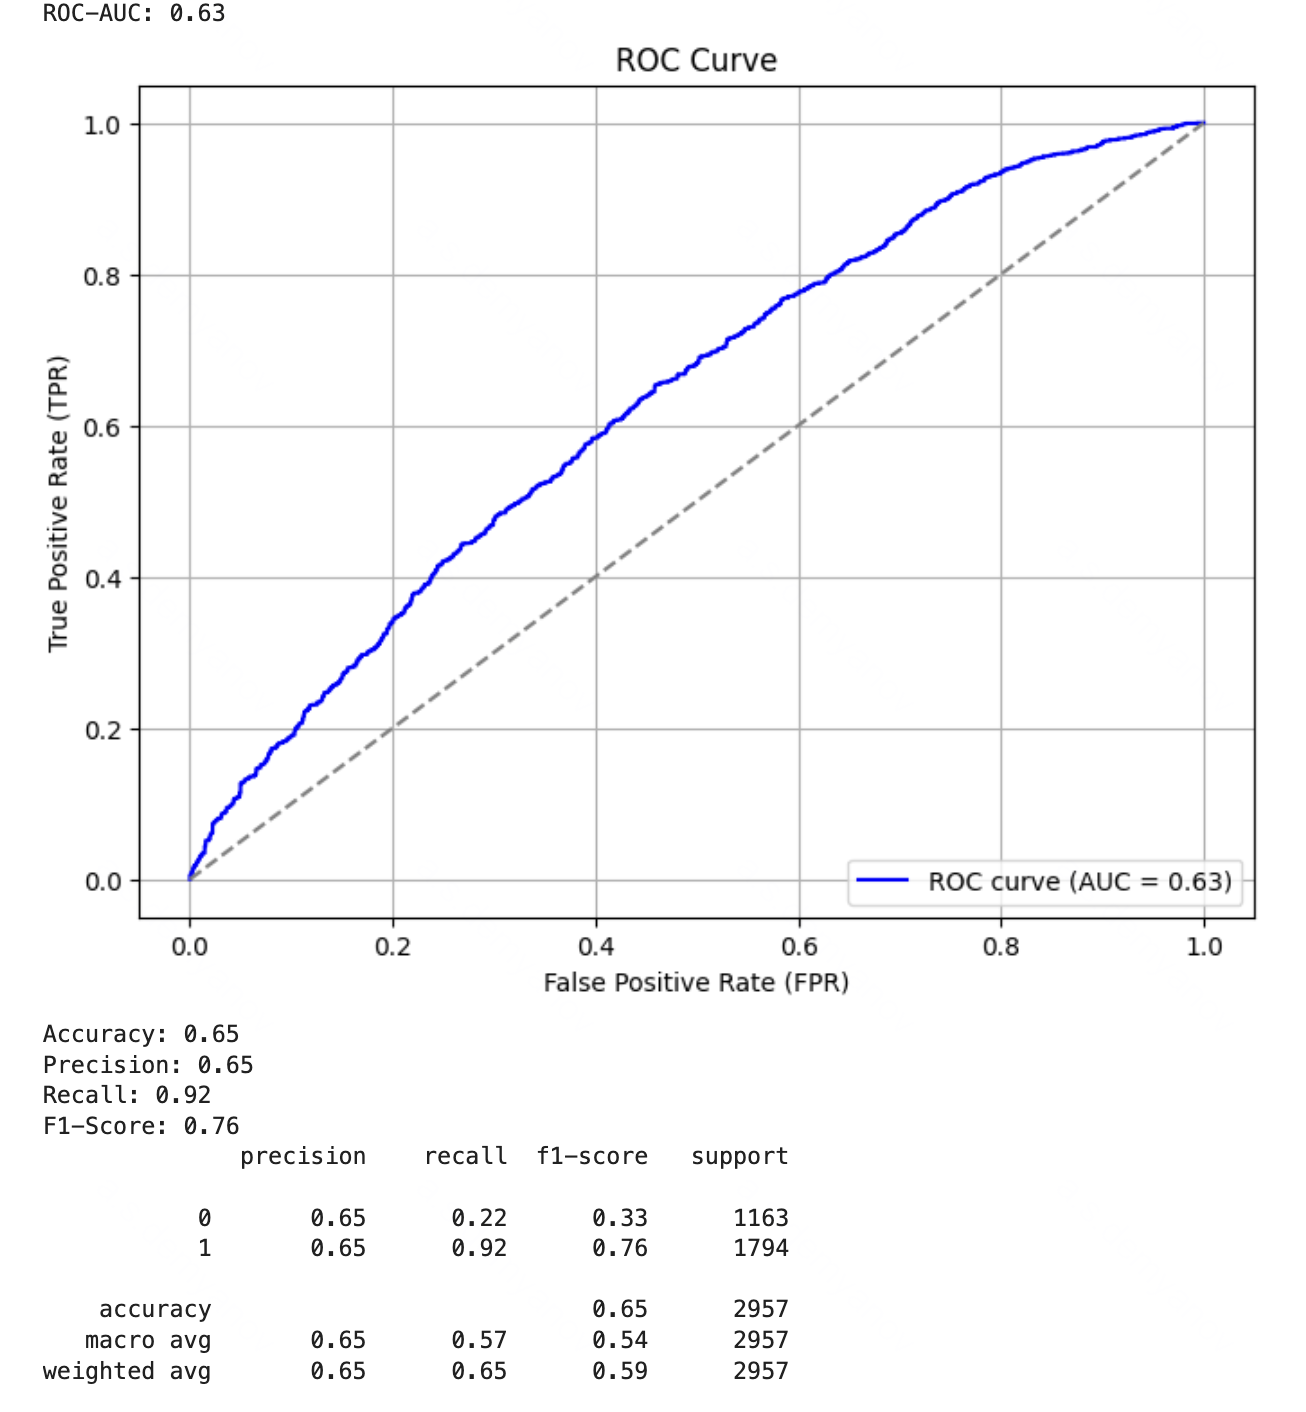

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score

# 1. Загрузка данных
data = df_clear  # Замените названия столбцов при необходимости
X = data['text']
y = data['target']

# 2. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Векторизация текста с помощью TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 4. Обучение модели Multinomial Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# 5. Предсказание вероятностей для тестовой выборки
y_prob = model.predict_proba(X_test_tfidf)[:, 1]  # Вероятности для класса 1

# 6. Расчёт ROC-кривой и выбор порога для FPR в диапазоне 5-10%
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Найти порог классификации для FPR в пределах [0.05, 0.10]
desired_fpr_range = (0.05, 0.10)
threshold_index = next(i for i in range(len(fpr)) if desired_fpr_range[0] <= fpr[i] <= desired_fpr_range[1])
optimal_threshold = thresholds[threshold_index]

print(f"Optimal Threshold for FPR in range {desired_fpr_range}: {optimal_threshold:.4f}")
print(f"ROC-AUC: {roc_auc:.2f}")

# 7. Применение найденного порога к предсказаниям
y_pred_custom_threshold = (y_prob >= optimal_threshold).astype(int)

# Оценка модели при выбранном пороге
accuracy = accuracy_score(y_test, y_pred_custom_threshold)
precision = precision_score(y_test, y_pred_custom_threshold)
recall = recall_score(y_test, y_pred_custom_threshold)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Построение ROC-кривой (опционально)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
plt.scatter(fpr[threshold_index], tpr[threshold_index], color='red', label=f'Chosen Threshold (FPR={fpr[threshold_index]:.2f}, TPR={tpr[threshold_index]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Линия случайного угадывания
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


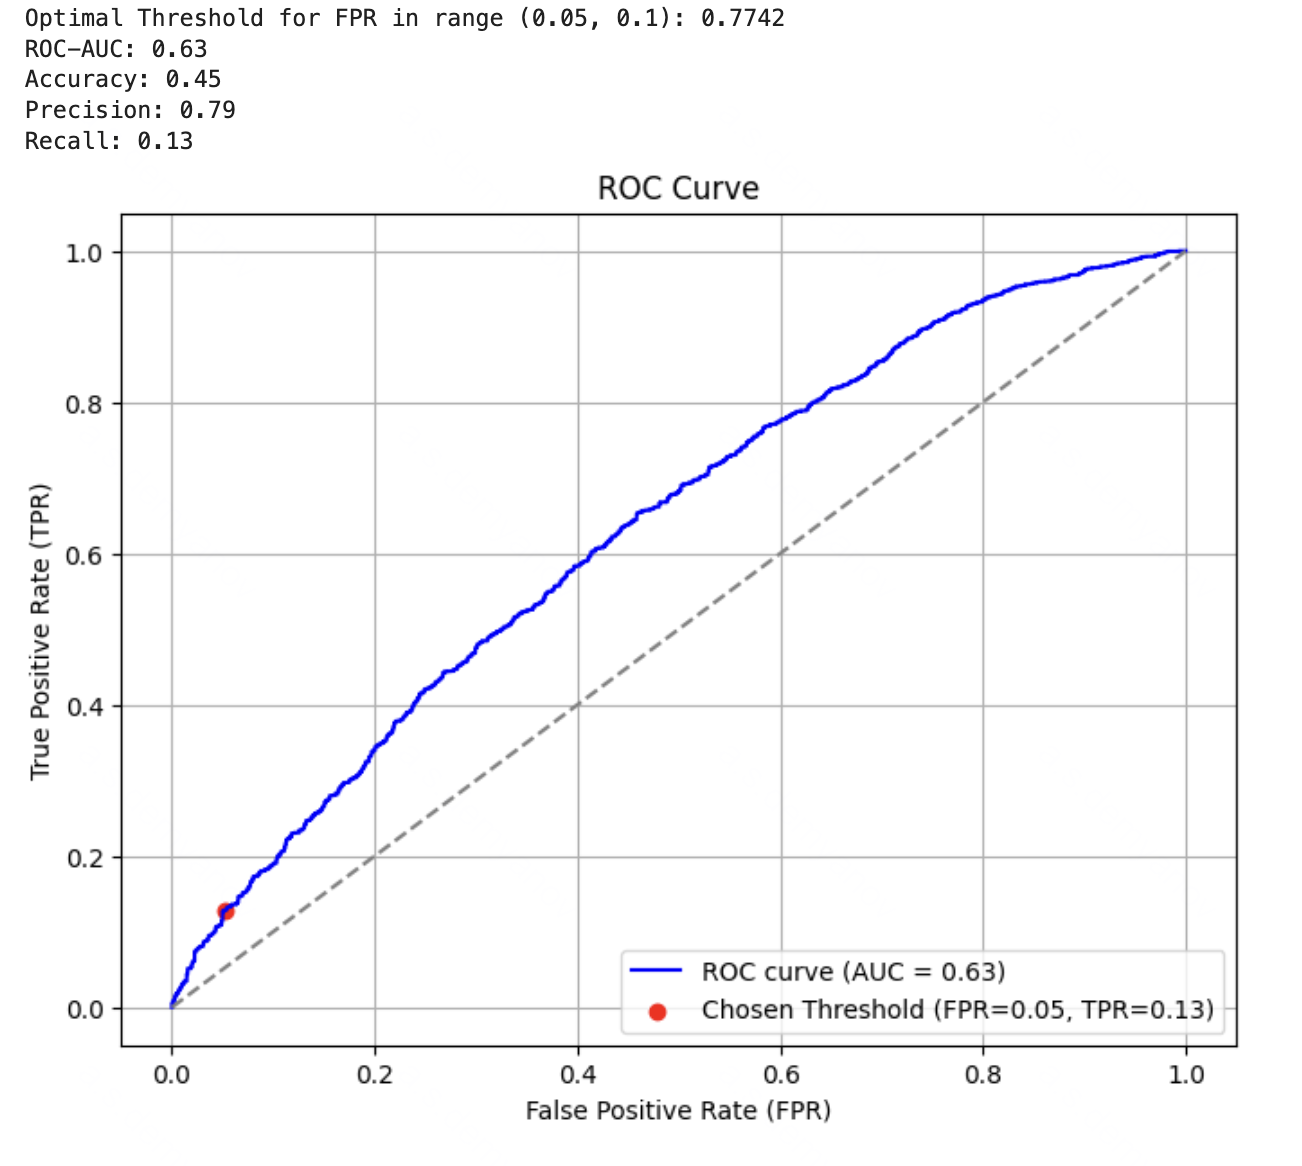

# 4. Векторизация
в коде присутствует NDA, поэтому код не могу раскрыть - по итогу получился векторизованный датасет, который я смог передать дополнительно в Catboost и E5_large

## Наивный Байес (на векторизованных данных)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

# 1. Загрузка данных
data = daf  # Замените названия столбцов при необходимости
X = data['text']
y = data['target']

# 2. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Векторизация текста с помощью TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Можно настроить параметры
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 4. Обучение модели Multinomial Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# 5. Предсказание вероятностей для тестовой выборки
y_prob = model.predict_proba(X_test_tfidf)[:, 1]  # Вероятности для класса 1

# 6. Расчёт TPR, FPR и ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Вывод ROC-AUC
print(f"ROC-AUC: {roc_auc:.2f}")

# 7. Построение ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Линия случайного угадывания
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# # 5. Предсказание и оценка модели
y_pred = model.predict(X_test_tfidf)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# 6. Пример предсказания для нового текста
# new_text = ["пример нового текста для классификации"]
# new_text_tfidf = vectorizer.transform(new_text)
# prediction = model.predict(new_text_tfidf)
# print(f"Предсказанный класс: {prediction[0]}")


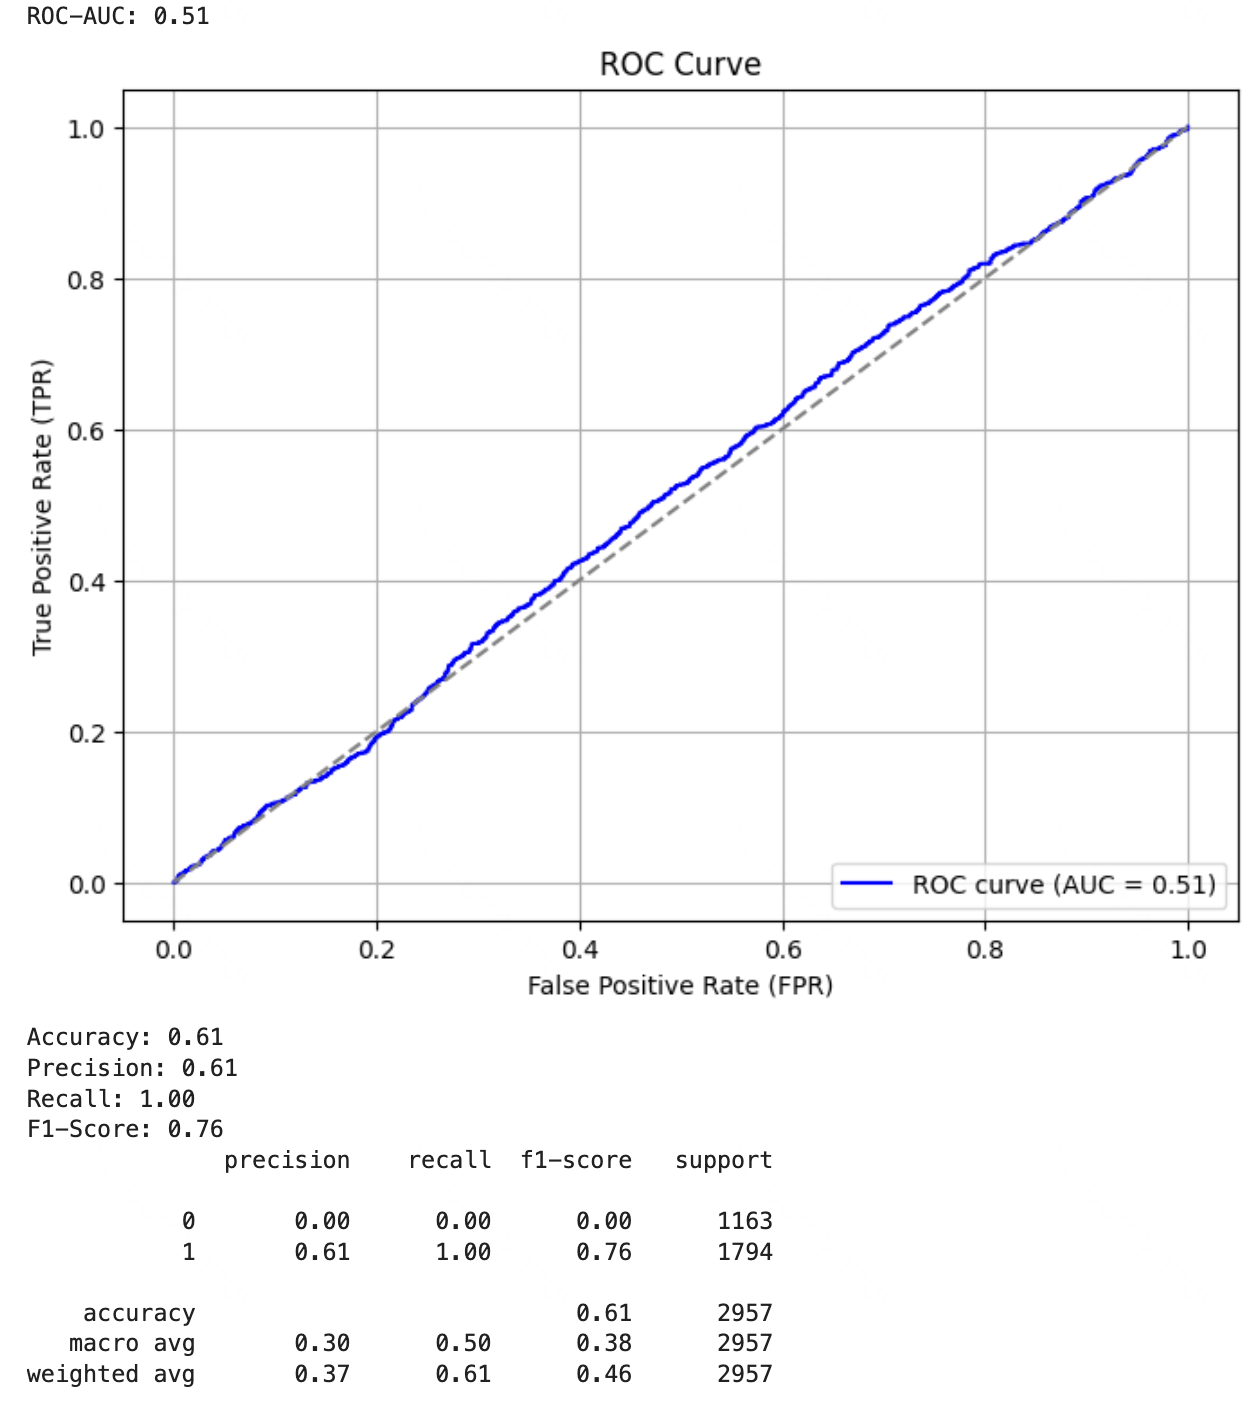

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score

# 1. Загрузка данных
data = daf  # Замените названия столбцов при необходимости
X = data['text']
y = data['target']

# 2. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Векторизация текста с помощью TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 4. Обучение модели Multinomial Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# 5. Предсказание вероятностей для тестовой выборки
y_prob = model.predict_proba(X_test_tfidf)[:, 1]  # Вероятности для класса 1

# 6. Расчёт ROC-кривой и выбор порога для FPR в диапазоне 5-10%
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Найти порог классификации для FPR в пределах [0.05, 0.10]
desired_fpr_range = (0.05, 0.10)
threshold_index = next(i for i in range(len(fpr)) if desired_fpr_range[0] <= fpr[i] <= desired_fpr_range[1])
optimal_threshold = thresholds[threshold_index]

print(f"Optimal Threshold for FPR in range {desired_fpr_range}: {optimal_threshold:.4f}")
print(f"ROC-AUC: {roc_auc:.2f}")

# 7. Применение найденного порога к предсказаниям
y_pred_custom_threshold = (y_prob >= optimal_threshold).astype(int)

# Оценка модели при выбранном пороге
accuracy = accuracy_score(y_test, y_pred_custom_threshold)
precision = precision_score(y_test, y_pred_custom_threshold)
recall = recall_score(y_test, y_pred_custom_threshold)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Построение ROC-кривой (опционально)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
plt.scatter(fpr[threshold_index], tpr[threshold_index], color='red', label=f'Chosen Threshold (FPR={fpr[threshold_index]:.2f}, TPR={tpr[threshold_index]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Линия случайного угадывания
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


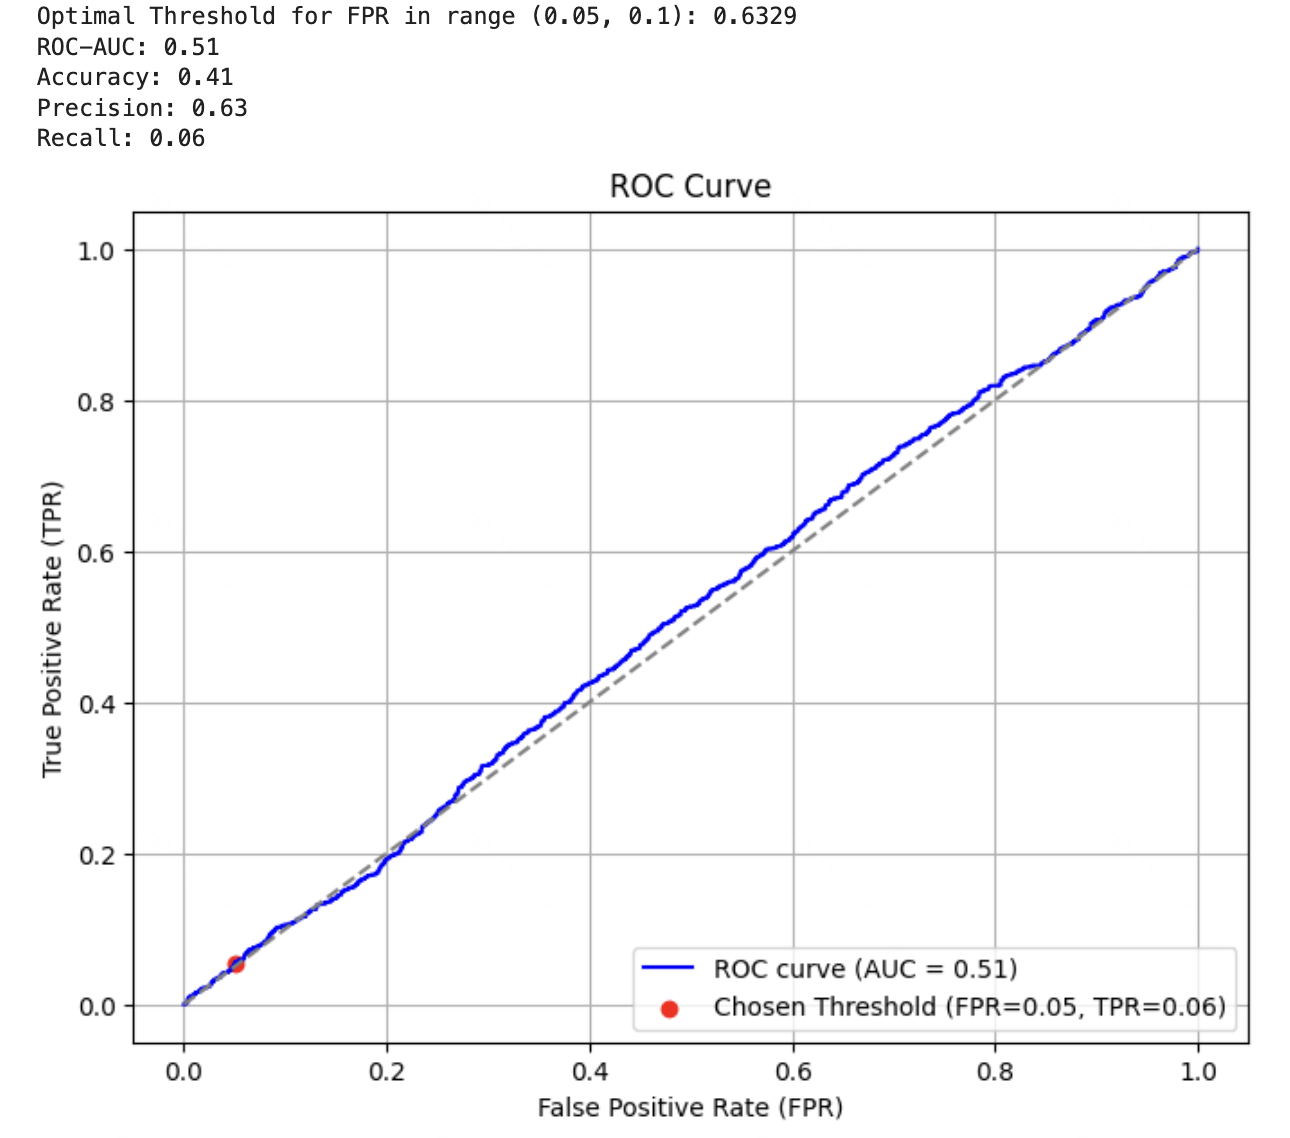